# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = "./data/train.p"
validation_file= "./data/valid.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
print(f"shape of X_train: {X_train.shape}")
print(f"shape of y_train: {y_train.shape}")

shape of X_train: (34799, 32, 32, 3)
shape of y_train: (34799,)


In [5]:
y_train[0]

41

In [6]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of a traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [7]:
sign_name = pd.read_csv("signnames.csv")
sign_name.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


### Training set visualization

In [8]:
def y_id_label(y_arr, sign_name):
    """
    add label to y_tain, y_valid
    """
    y_df = pd.DataFrame(y_arr, columns=["id"])
    y_df["imgId"] = np.arange(y_arr.shape[0])
    y_df = y_df.reindex(columns=["imgId", "id"])
    y_df_name = y_df.merge(sign_name, how="left", left_on="id", right_on="ClassId")
    y_df_name.drop(["id"], axis=1, inplace=True)
    
    return y_df_name

In [9]:
def choose_img_to_plot(y_df_name, X_arr, num_per_cat=5):
    """
    choose num_per_cat images from each category randomly, append them to img_plot_arr
    """
    img_plot_arr = []
    for cat_id in range(43):  #there are 43 categories
        img_id_list = list(y_df_name[y_df_name["ClassId"]==cat_id]["imgId"])
        img_id_rdm = random.sample(img_id_list, num_per_cat)
        # print(f"cat_id : {cat_id}, img_id_rdm: {img_id_rdm}")
        img_plot_arr.append(X_arr[img_id_rdm])
        
    return img_plot_arr

In [10]:
def plot_X_img_plot_arr(img_plot_arr, sign_name, num_per_cat=5):
    """
    plot the img_plot_arr from choose_img_to_plot() function
    """
    for cat_id in range(43):
        fig, axes = plt.subplots(1, num_per_cat, figsize=(9,9))
        
        for img_idx in range(num_per_cat):
            img = img_plot_arr[cat_id][img_idx]
            axes[img_idx].imshow(img) 
        fig.suptitle(f"cat_id: {cat_id}; lable: {sign_name.iloc[cat_id,1]}", y=0.6)
        fig.tight_layout()

**Show the number of each categories in training data set**

In [11]:
y_train_name = y_id_label(y_train, sign_name)
y_train_name.head()

,imgId,ClassId,SignName
0,0,41,End of no passing
1,1,41,End of no passing
2,2,41,End of no passing
3,3,41,End of no passing
4,4,41,End of no passing


<AxesSubplot:>

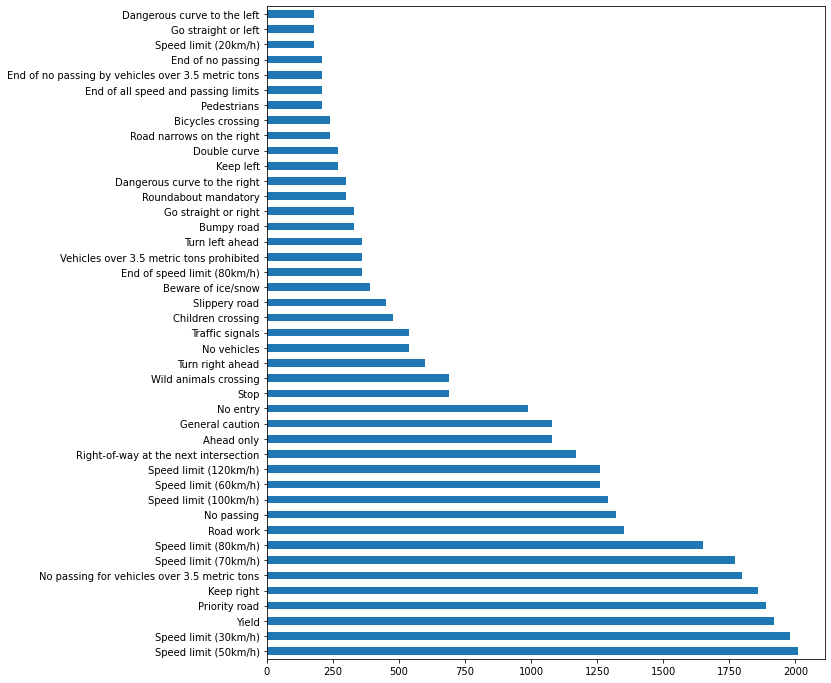

In [12]:
y_train_name["SignName"].value_counts().plot(kind="barh",figsize=(10, 12))

**Show five images of each category**

In [13]:
X_train_img_plot_arr = choose_img_to_plot(y_train_name, X_train, num_per_cat=5)

C:\Users\ychen\AppData\Local\Temp/ipykernel_10932/1905436214.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, num_per_cat, figsize=(9,9))


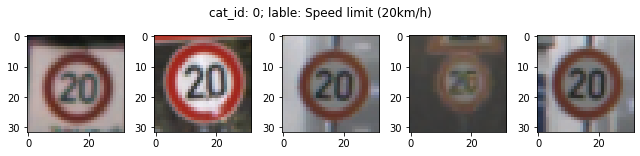

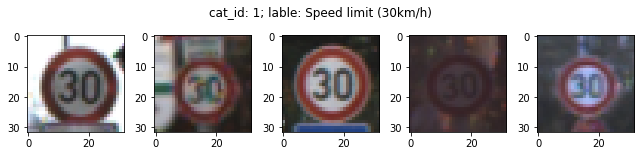

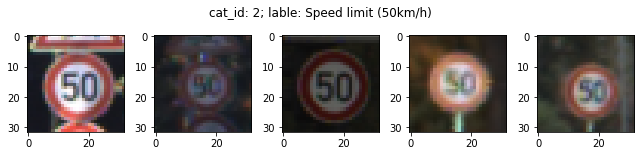

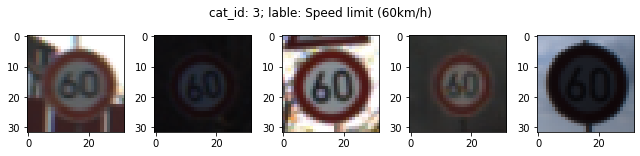

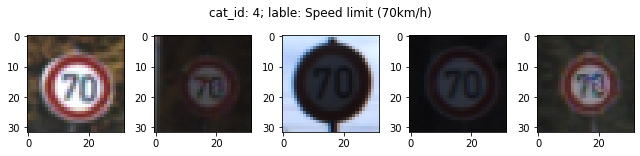

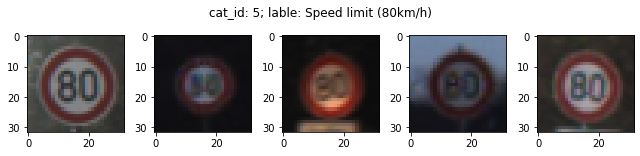

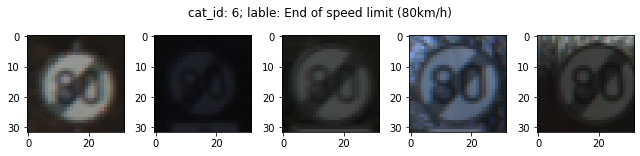

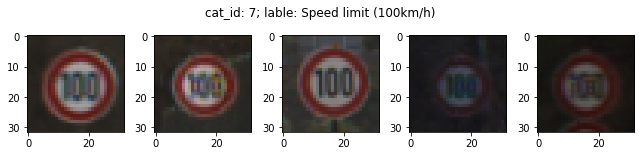

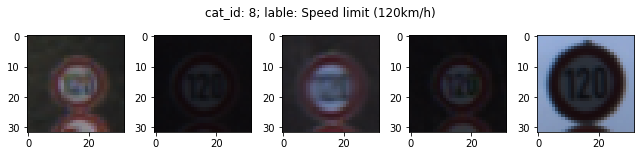

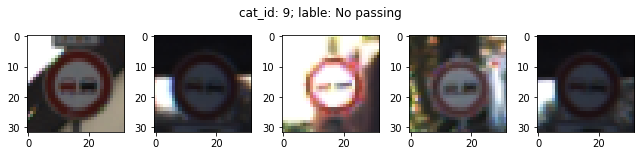

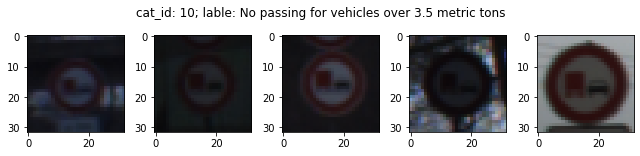

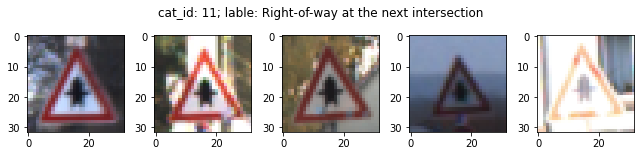

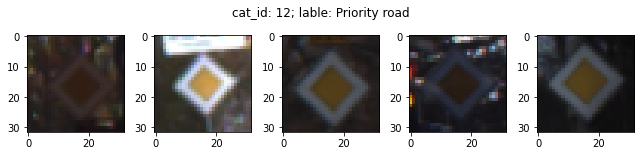

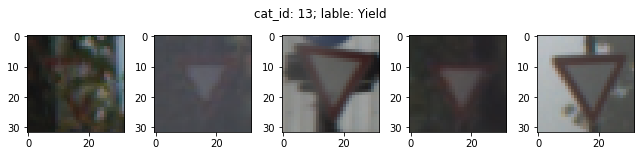

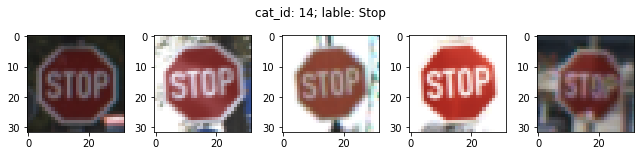

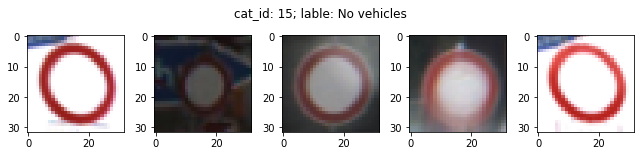

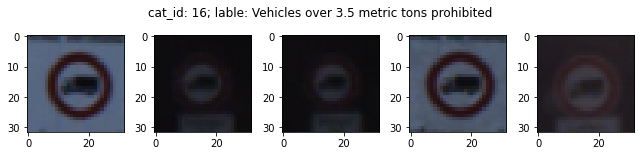

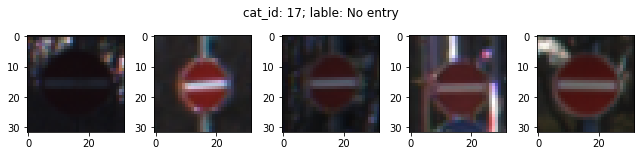

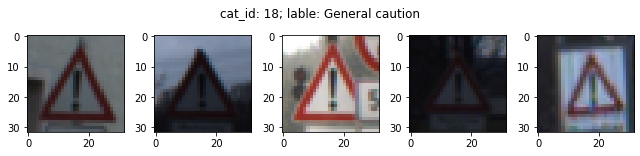

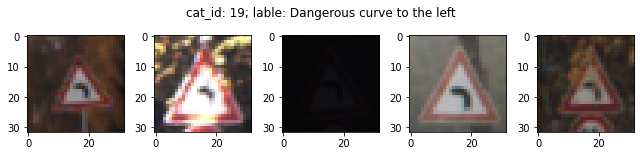

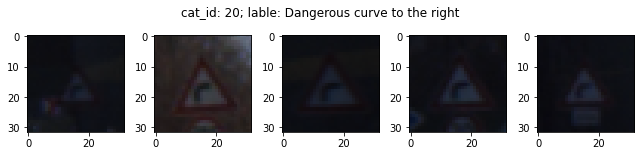

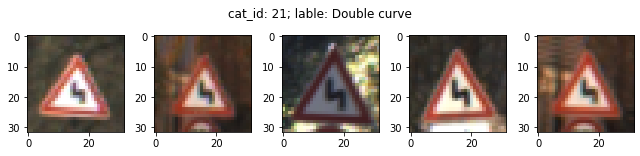

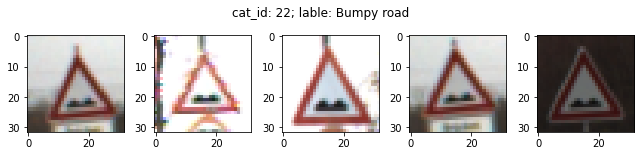

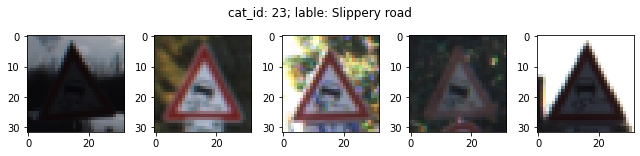

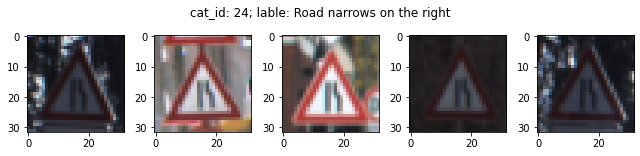

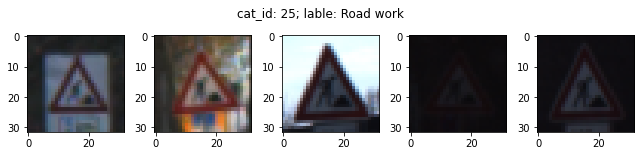

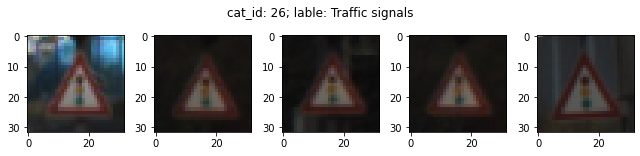

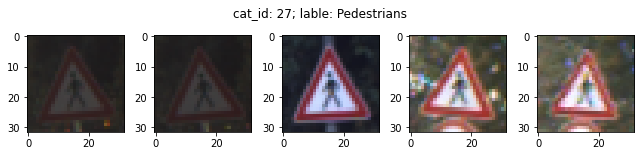

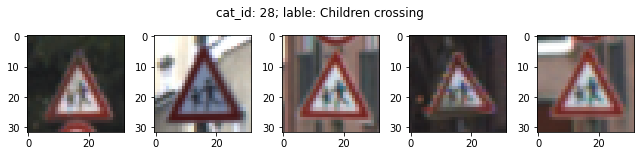

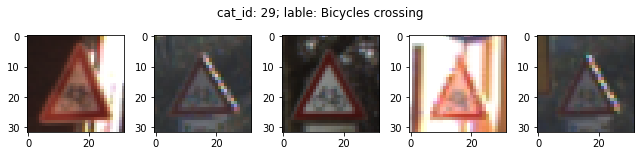

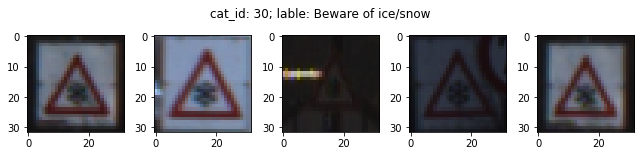

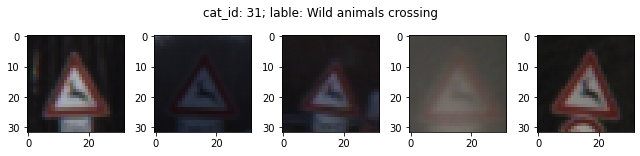

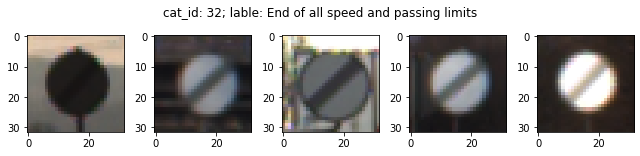

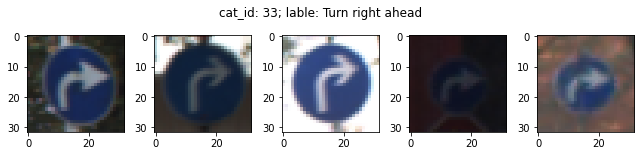

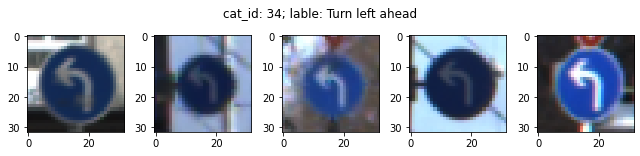

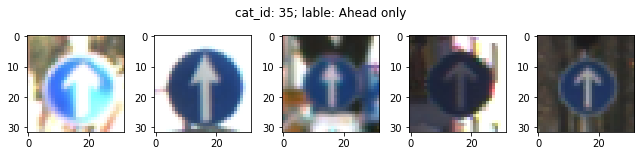

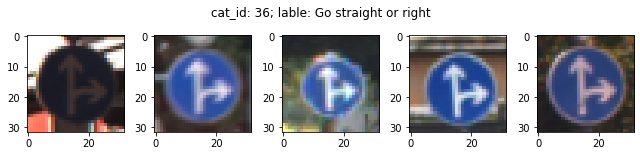

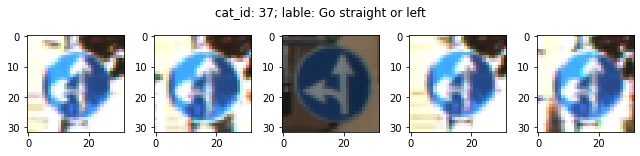

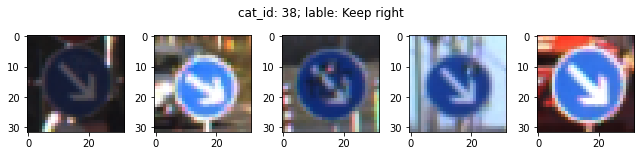

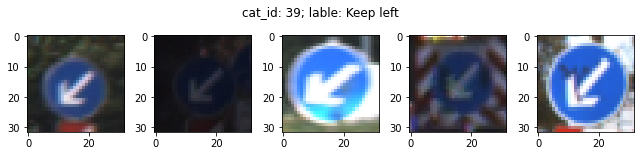

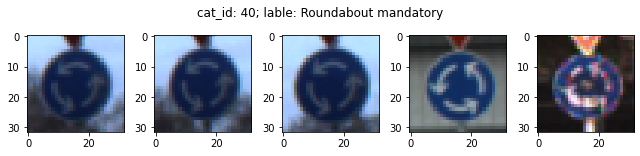

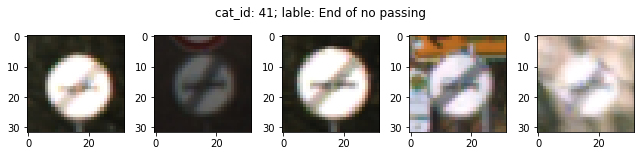

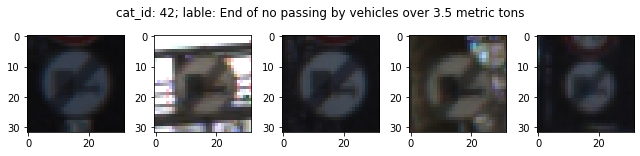

In [14]:
plot_X_img_plot_arr(X_train_img_plot_arr, sign_name, num_per_cat=5)

### Validation set distribution

**Show the number of each categories in validation data set**

In [15]:
y_valid_name = y_id_label(y_valid, sign_name)
y_valid_name.head()

,imgId,ClassId,SignName
0,0,41,End of no passing
1,1,41,End of no passing
2,2,41,End of no passing
3,3,41,End of no passing
4,4,41,End of no passing


<AxesSubplot:>

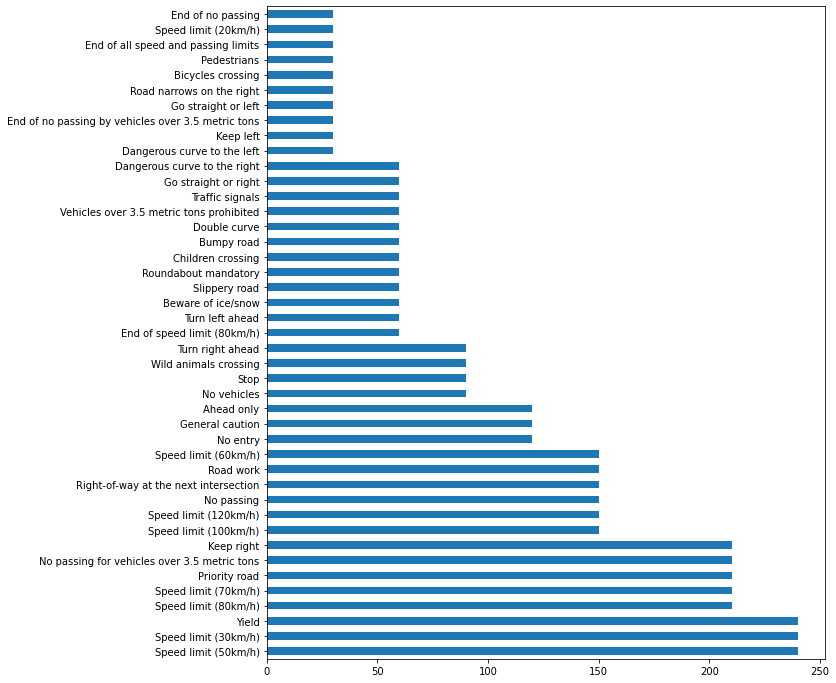

In [16]:
y_valid_name["SignName"].value_counts().plot(kind="barh",figsize=(10, 12))

**Show five images of each category**

In [17]:
X_valid_img_plot_arr = choose_img_to_plot(y_valid_name, X_valid, num_per_cat=5)

C:\Users\ychen\AppData\Local\Temp/ipykernel_10932/1905436214.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, num_per_cat, figsize=(9,9))


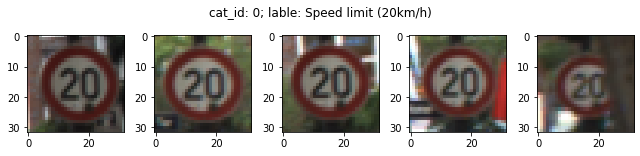

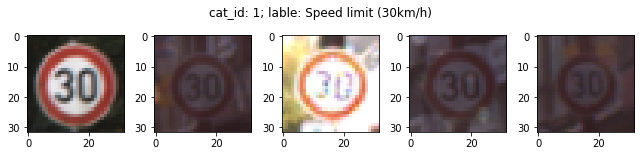

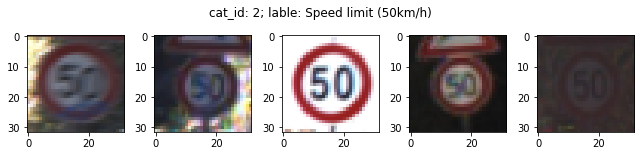

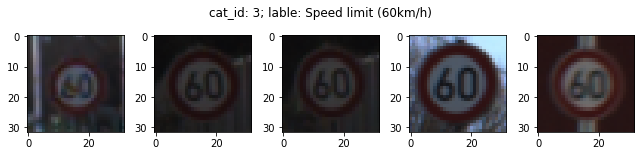

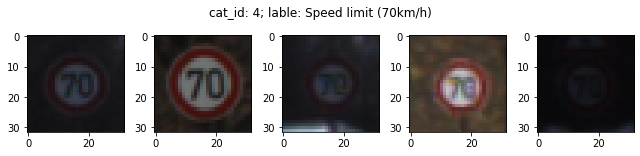

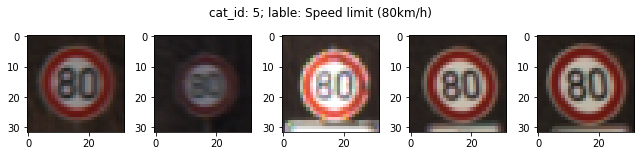

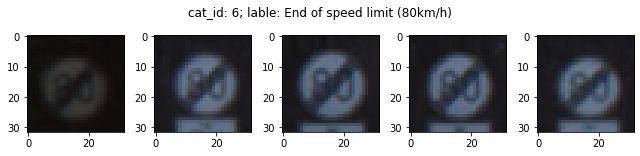

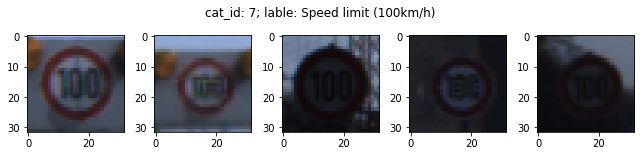

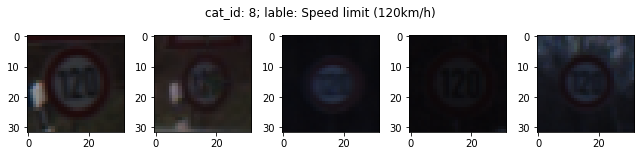

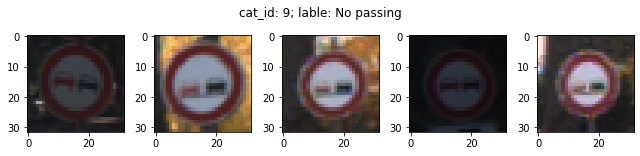

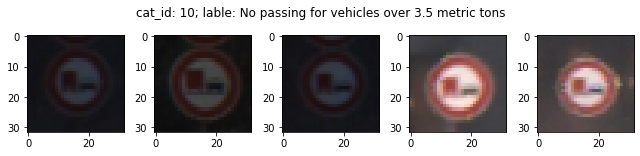

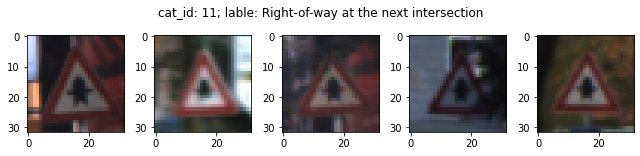

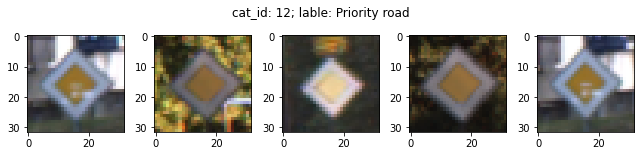

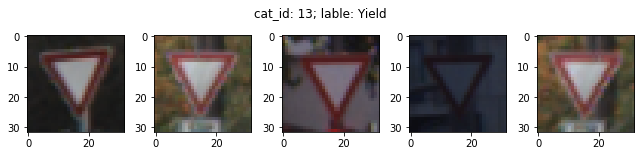

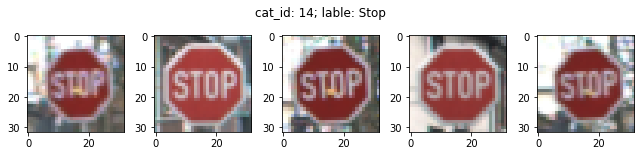

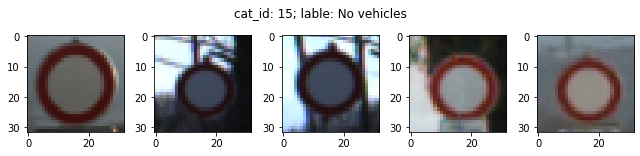

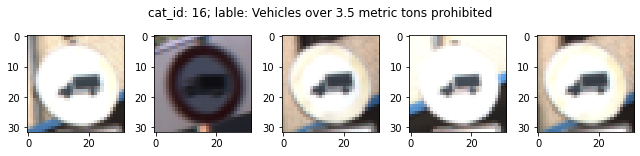

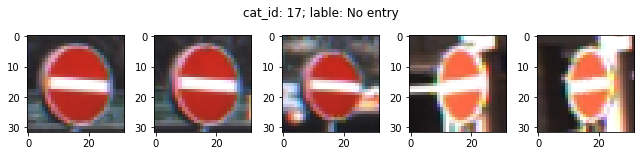

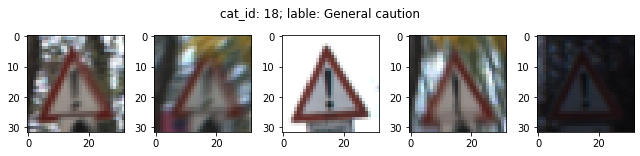

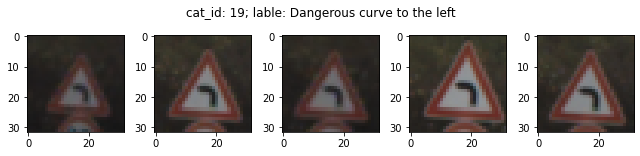

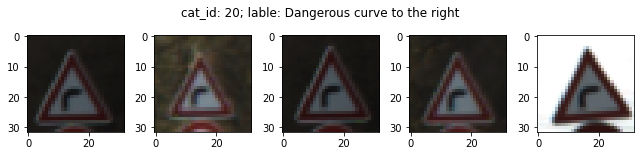

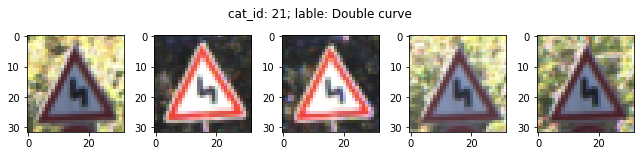

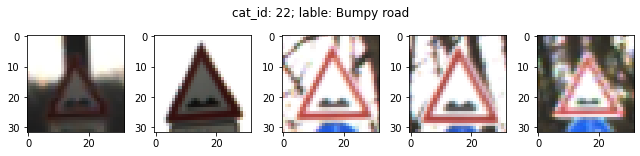

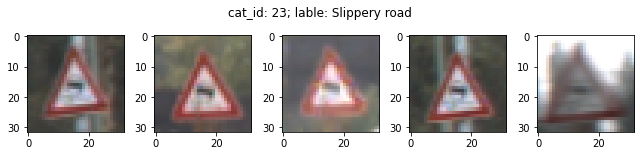

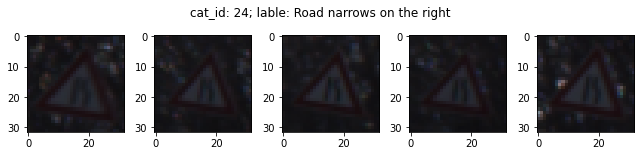

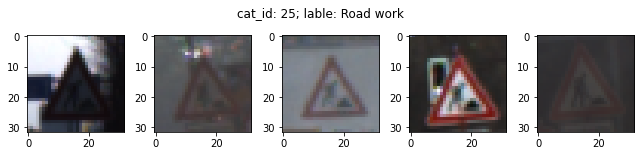

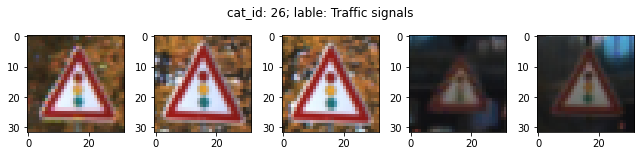

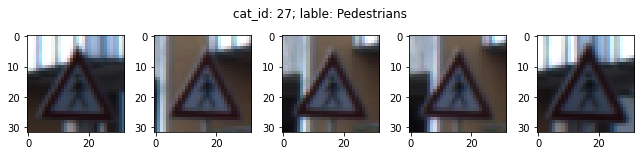

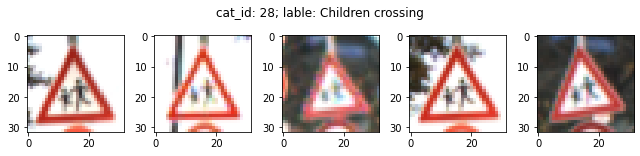

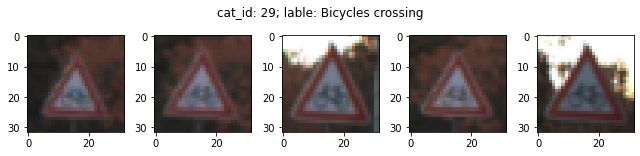

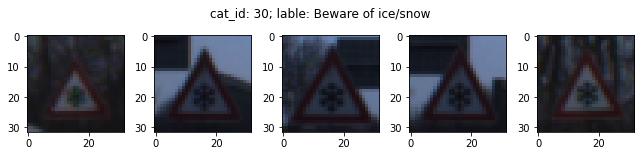

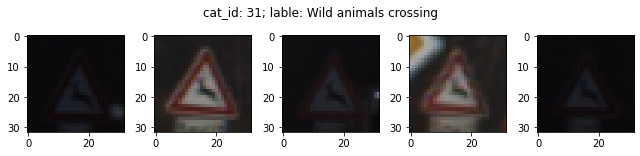

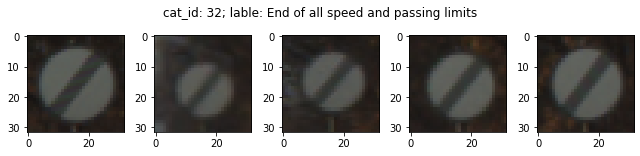

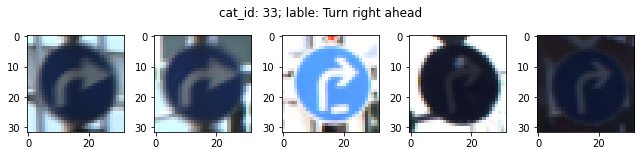

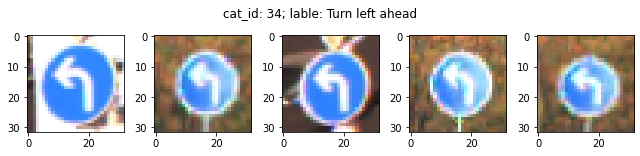

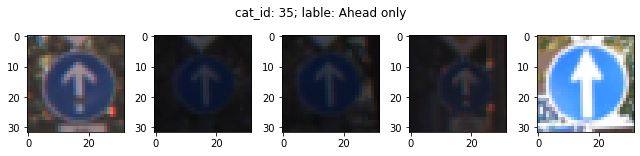

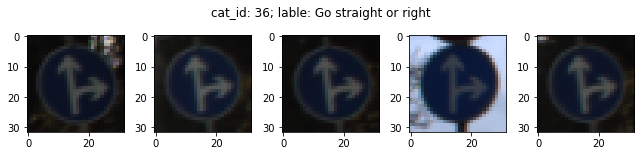

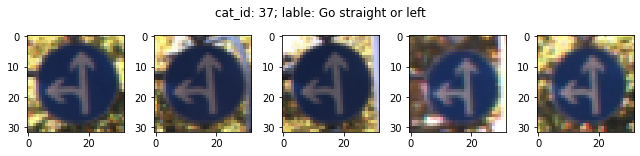

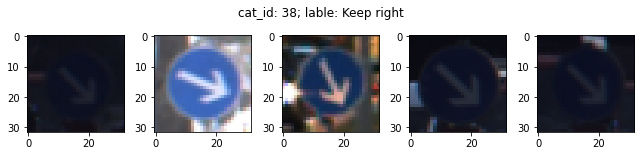

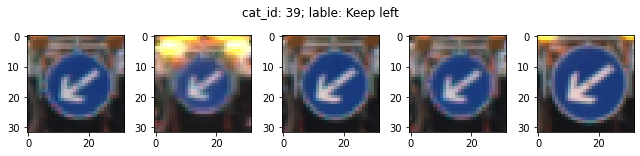

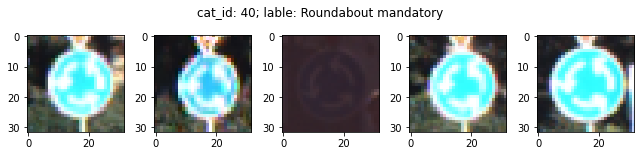

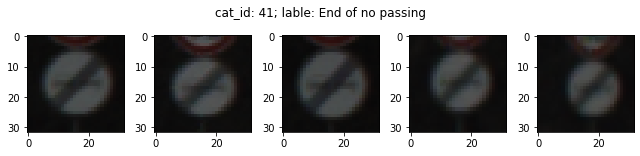

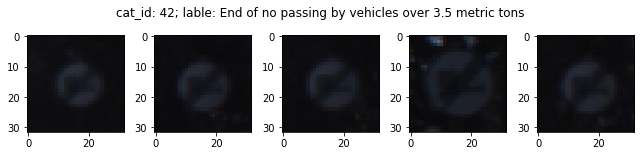

In [18]:
plot_X_img_plot_arr(X_valid_img_plot_arr, sign_name, num_per_cat=5)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Normalization

In [19]:
def norm_gray(color_images):
    # grayscale
    grayscaled_images = np.sum(color_images/3, axis=3, keepdims=True)
    
    # normalize
    normalized_images = (grayscaled_images - 128) / 128
    
    return normalized_images

In [20]:
# def norm_gray(color_images):
    
#     # normalize
#     normalized_images = (color_images - 128) / 128
    
#     # grayscale
#     grayscaled_images = np.sum(normalized_images/3, axis=3, keepdims=True)
    
#     return grayscaled_images

In [21]:
X_train_normgray = norm_gray(X_train)
X_valid_normgray = norm_gray(X_valid)
X_test_normgray = norm_gray(X_test)

In [22]:
np.max(X_train[888])

172

In [23]:
np.max(X_train_normgray[888])

0.31770833333333326

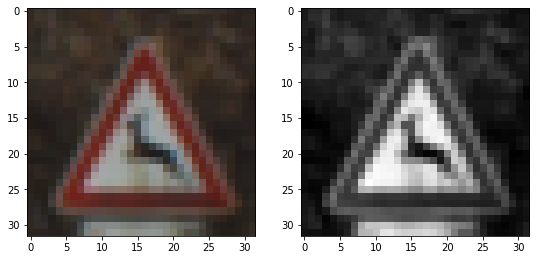

In [24]:
#choose image 888 as an example
fig, axes = plt.subplots(1,2, figsize=(9,9))
axes[0].imshow(X_train[888])
axes[1].imshow(X_train_normgray[888], cmap='gray')
plt.show()

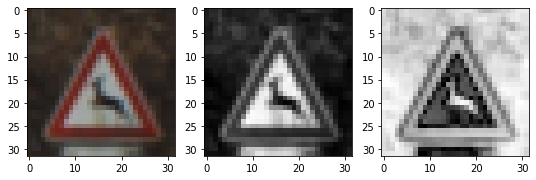

In [25]:
#choose image 888 as an example
fig, axes = plt.subplots(1,3, figsize=(9,9))
axes[0].imshow(X_train[888])
axes[1].imshow(X_train_normgray[888], cmap='gray')
axes[2].imshow(abs(X_train_normgray[888]), cmap='gray')
plt.show()

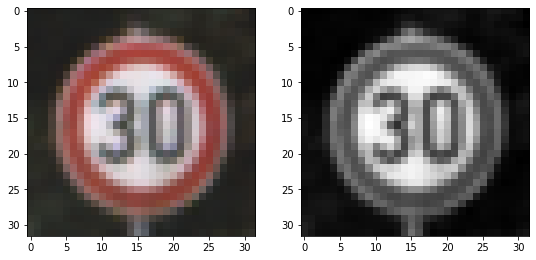

In [26]:
#choose image 888 as an example
fig, axes = plt.subplots(1,2, figsize=(9,9))
axes[0].imshow(X_valid[500])
axes[1].imshow(X_valid_normgray[500], cmap='gray')
plt.show()

In [27]:
#change chanel from N*H*W*C to N*C*H*W), then transform to tensor
X_train_tensor = torch.from_numpy(np.transpose(X_train_normgray, [0,3,1,2])).float()
X_valid_tensor = torch.from_numpy(np.transpose(X_valid_normgray, [0,3,1,2])).float()
X_test_tensor = torch.from_numpy(np.transpose(X_test_normgray, [0,3,1,2])).float()

In [28]:
# #change chanel from N*H*W*C to N*C*H*W), then transform to tensor
# X_train_prep = np.transpose(X_train_normgray, [0,3,1,2])
# X_valid_prep = np.transpose(X_valid_normgray, [0,3,1,2])
# X_test_prep = np.transpose(X_test_normgray, [0,3,1,2])

In [29]:
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, torch.tensor(y_valid))
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

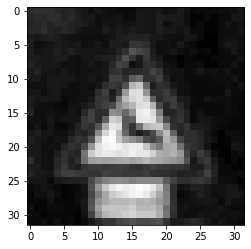

In [30]:
plt.imshow(np.squeeze(valid_dataset[60][0]), cmap='gray')

### Model Architecture

In [31]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        #input is 32*32
        ## https://pytorch.org/docs/1.9.1/generated/torch.nn.Conv2d.html
        #(32+2*2-1*4-1)/1+1=32
        # the output Tensor for one image, will have the dimensions: (6, 32, 32)
        # after one pool layer, this becomes (6, 16, 16)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # second conv layer: 6 inputs, 16 outputs, 5x5 conv
        ## output size = (16+2*0-1*4-1)/1+1=12
        # the output tensor will have dimensions: (16, 12, 12)
        # after another pool layer this becomes (16, 6, 6); 
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        
        # 16 outputs * the 6*6 filtered/pooled map size
        # 10 output channels (for the 43 classes)
        self.fc1 = nn.Linear(16*6*6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)
        

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        
        # three linear layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # a softmax layer to convert the 43 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        
        # final output
        return x

# instantiate and print your Net
lenet = LeNet()
print(lenet)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=43, bias=True)
)


In [32]:
# cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.NLLLoss()

## TODO: specify optimizer 
# stochastic gradient descent with a small learning rate
optimizer = optim.SGD(lenet.parameters(), lr=0.001)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [33]:
def train(n_epochs, model_net, data_loader):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        for batch_i, data in enumerate(data_loader):
            # get the input images and their corresponding labels
            inputs, labels = data
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            # forward pass to get outputs
            outputs = model_net(inputs)
            # calculate the loss
            loss = criterion(outputs, labels)
            # backward pass to calculate the parameter gradients
            loss.backward()
            # update the parameters
            optimizer.step()
            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            # loss_over_time.append(loss.item())
            
            
        ave_log = running_loss / len(data_loader)
        loss_over_time.append(ave_log)
        print(f"Epoch: {epoch} --- loss: {ave_log}")
            # if batch_i % 100 == 99:    # print every 100 batches
            #     avg_loss = running_loss/100
            #     # record and print the avg loss over the 1000 batches
            #     loss_over_time.append(avg_loss)
            #     print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
            #     running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [34]:
# define the number of epochs to train for
n_epochs = 250 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs, lenet, train_loader)

Epoch: 0 --- loss: 3.776311192442389
Epoch: 1 --- loss: 3.7632854094400123
Epoch: 2 --- loss: 3.750275647815536
Epoch: 3 --- loss: 3.7355738352326786
Epoch: 4 --- loss: 3.7163015016738106
Epoch: 5 --- loss: 3.683510454262004
Epoch: 6 --- loss: 3.6136623305432938
Epoch: 7 --- loss: 3.534136801958084
Epoch: 8 --- loss: 3.5006532651536606
Epoch: 9 --- loss: 3.48813693050076
Epoch: 10 --- loss: 3.4820910249562824
Epoch: 11 --- loss: 3.4775960839846554
Epoch: 12 --- loss: 3.473878367420505
Epoch: 13 --- loss: 3.4706173946752266
Epoch: 14 --- loss: 3.4674485531799935
Epoch: 15 --- loss: 3.4642759158330807
Epoch: 16 --- loss: 3.461401682566194
Epoch: 17 --- loss: 3.4581856490934597
Epoch: 18 --- loss: 3.454798834727091
Epoch: 19 --- loss: 3.4509778693318367
Epoch: 20 --- loss: 3.446587163297569
Epoch: 21 --- loss: 3.4412953695830177
Epoch: 22 --- loss: 3.4346288797609947
Epoch: 23 --- loss: 3.426328808069229
Epoch: 24 --- loss: 3.416151044999852
Epoch: 25 --- loss: 3.4036673728157494
Epoch: 2

KeyboardInterrupt: 

In [ ]:
plt.plot(training_loss)

In [ ]:
torch.save(lenet.state_dict(), "lenet_epoch250.pt")

In [ ]:
lenet.eval()
test_loss = 0.0
correct = 0

for batch_i, data in enumerate(valid_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = lenet(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss += loss
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct += (predicted == labels).type(torch.float).sum().item()
    
ave_test_loss = test_loss / len(valid_loader)
accu = correct / len(valid_loader.dataset)
print(f"ave_test_loss: {ave_test_loss}\naccu:{accu}")

In [ ]:
len(valid_loader.dataset)

In [ ]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()
preds = np.squeeze(lenet(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()
preds

In [ ]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()
outputs = lenet(images)
_, predicted = torch.max(outputs.data, 1)
predicted

In [ ]:
predicted.eq(labels).sum().item()

**LeNet with Dropout**

In [45]:
class LeNet_Dropout(nn.Module):

    def __init__(self):
        super(LeNet_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # dropout with p=0.4
        self.conv2_drop = nn.Dropout(p=0.75)
        self.fc1 = nn.Linear(16*6*6, 120)
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(120, 84)
        # dropout with p=0.2
        self.fc2_drop = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_drop(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        
        return x

lenet_dropout = LeNet_Dropout()
print(lenet_dropout)

LeNet_Dropout(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout(p=0.75, inplace=False)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=84, out_features=43, bias=True)
)


In [46]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(lenet_dropout.parameters(), lr=0.001)

In [47]:
def train(n_epochs, model_net, data_loader):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        for batch_i, data in enumerate(data_loader):
            # get the input images and their corresponding labels
            inputs, labels = data
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            # forward pass to get outputs
            outputs = model_net(inputs)
            # calculate the loss
            loss = criterion(outputs, labels)
            # backward pass to calculate the parameter gradients
            loss.backward()
            # update the parameters
            optimizer.step()
            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            # loss_over_time.append(loss.item())
            
        ave_log = running_loss / len(data_loader)
        loss_over_time.append(ave_log)
        print(f"Epoch: {epoch} --- loss: {ave_log}")
            # if batch_i % 100 == 99:    # print every 100 batches
            #     avg_loss = running_loss/100
            #     # record and print the avg loss over the 1000 batches
            #     loss_over_time.append(avg_loss)
            #     print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
            #     running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [48]:
# define the number of epochs to train for
n_epochs = 250 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs, lenet_dropout, train_loader)

Epoch: 0 --- loss: 3.765554292675327
Epoch: 1 --- loss: 3.754927990191123
Epoch: 2 --- loss: 3.7449394482023575
Epoch: 3 --- loss: 3.7350228652358055
Epoch: 4 --- loss: 3.7251770378035656
Epoch: 5 --- loss: 3.7149128208265587
Epoch: 6 --- loss: 3.7044873816125534
Epoch: 7 --- loss: 3.692292402334073
Epoch: 8 --- loss: 3.6781049822183216
Epoch: 9 --- loss: 3.6561719586744026
Epoch: 10 --- loss: 3.6194385461070957
Epoch: 11 --- loss: 3.574319203986841
Epoch: 12 --- loss: 3.5387358888983727
Epoch: 13 --- loss: 3.5224738002699962
Epoch: 14 --- loss: 3.511039400801939
Epoch: 15 --- loss: 3.5052154804853832
Epoch: 16 --- loss: 3.498826427933048
Epoch: 17 --- loss: 3.4975086862550064
Epoch: 18 --- loss: 3.495882747366148
Epoch: 19 --- loss: 3.4935457027133774
Epoch: 20 --- loss: 3.49011941999197
Epoch: 21 --- loss: 3.4884071819045963
Epoch: 22 --- loss: 3.488047203158631
Epoch: 23 --- loss: 3.4840638843529366
Epoch: 24 --- loss: 3.4831455161466316
Epoch: 25 --- loss: 3.481221988797188
Epoch: 

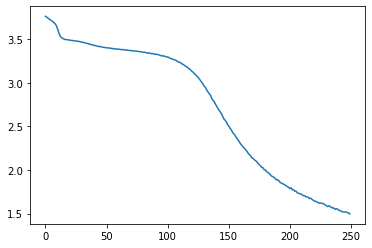

In [49]:
plt.plot(training_loss)

In [50]:
torch.save(lenet.state_dict(), "lenet_dropout_epoch250.pt")

In [51]:
lenet.eval()
test_loss = 0.0
correct = 0

for batch_i, data in enumerate(valid_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = lenet_dropout(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss += loss
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct += (predicted == labels).type(torch.float).sum().item()
    
ave_test_loss = test_loss / len(valid_loader)
accu = correct / len(valid_loader.dataset)
print(f"ave_test_loss: {ave_test_loss}\naccu:{accu}")

ave_test_loss: 1.660723090171814
accu:0.5015873015873016


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")